<a href="https://colab.research.google.com/github/Maksim2809/Old_HomeWork_Numerical_Methods/blob/main/ARIMA_Mihailov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st
import math
from scipy.optimize import fsolve

def linage_regress(X,Y):
    """
    Линейная регресси (оценки методом моментов)

      Параметры:
        X (list): Feature matrix
        Y (list): target

      return:
        tuple: tuple из коэффициентов регрессии и списка прогноза
    """
    n = len(X)
    sg_e = 1.0
    Ex = np.mean(X)
    Ey = np.mean(Y)
    Dx = np.var(X)
    Dy = np.var(Y)
    cov_xy = np.cov(X,Y)[0][1]
    a = 0.05
    b1 = cov_xy/Dx
    b0 = Ey - b1*Ex
    '''
    print("b0: ",b0)
    print("b1: ",b1)
    '''
    x2 = np.array(X)**2
    Ex2 = np.mean(x2)
    #print("среднее квадратов X: ",Ex2)
    St_o2x = S_obr2x(a, n-2)
    #print("Значение обратной функции Стьюдента", St_o2x)
    y2 = np.array([b0+b1*i for i in X])
    e = (y2 - Y)**2
    De = np.var(e)
    Db0 = De*Ex2/(Dx*n)
    Db1 = De/(Dx*n)
    #print("дисп e: ", np.var(e))
    #print("дисп b0: ", Db0)
    #print("дисп b1 ", Db1)
    QR = np.var(Y)
    QL = np.mean(Y - (Y - y2)**2)
    R2 = 1 - QR/QL
    #print("коэффицент детерминации: ", R2)
    itrv_b0 = np.array([b0 - St_o2x[1]*np.math.sqrt(Db0),b0 + St_o2x[1]*np.math.sqrt(Db0)])
    itrv_b1 = np.array([b1 - St_o2x[1]*np.math.sqrt(Db0),b1 + St_o2x[1]*np.math.sqrt(Db0)])
    return b0, b1, y2

def afk(X, l = 50):
    """
    Автокорреляционная функция.
      Параметры:
          X (list): target
          l (int) : количество значений функции

      return:
          list: первые l значения АКФ
    """
    #l = math.floor(len(X)/2)-1
    akf = [np.corrcoef([
        X[i] for i in range(j+1,len(X))],
                       [X[k] for k in range(len(X) - j-1)])[0][1]
          for j in range(l)]
    #A = np.array([[1.0 if i==j else akf[j+i]  for j in range(n)] for i in range(n) ] )
    #B = np.array([ akf[i] for i in range(n)])

    #x = np.linalg.inv(A).dot(B)
    #return([akf,A,x])
    return akf

def AR1(X):
    """
    Коэффициент авторегрессии первого порядка (оценка методом моментов)
          Параметры:
            X (list): target

          return:
            float: коэфициент авторегрессии (без константы)
    """
    AKF = afk(X, 3)
    a = np.array(AKF[0])
    return a

def AR1_mnk(X):
    """
    Коэффициент авторегрессии первого порядка (оценка МНК)
          Параметры:
            X (list): target

          return:
            float: коэфициент авторегрессии (без константы)
    """
    n = len(X)
    a = sum([X[i]*X[i-1] for i in range(1,n)])/sum(X[1:n-2]**2)
    return a

def AR2(X):
    """
    Коэффициенты авторегрессии второго порядка (оценка методом моментов)
          Параметры:
            X (list): target

          return:
            tuple: коэфициенты авторегрессии (без константы)
    """
    r = afk(X)
    a2 = (r[1] -  r[0]**2)/(1 - r[0]**2)
    a1 = (r[0]*(1 - r[1]))/(1 - r[0]**2)
    return a1,a2

def AR2_mnk(X):
    """
    Коэффициенты авторегрессии второго порядка (оценка МНК)
          Параметры:
            X (list): target

          return:
            np.array: массив коэфициентов авторегрессии (без константы)
    """
    n = len(X)
    r = X[2:n-2]**2
    Xn2n1 =  sum([X[i-2]*X[i-1] for i in range(2,n)])
    A = np.array([
        [sum(X[1:n-2]**2),Xn2n1],
        [Xn2n1, sum(X[0:n-3]**2)]
        ])
    b = np.array([sum([X[i]*X[i-1]  for i in range(2,n)]),
                  sum([X[i]*X[i-2]  for i in range(2,n)])])
    res = np.linalg.solve(A,b)
    return res

def fitingAR1(X, mnk = False,drow = True, drow_e = True,hist_e = False):
    """
    Подгонка авторегресси первого порядка и её характеристики
    (+ подгоняется ряд остатков авторегрессией второго порядка)
          Параметры:
                  X (list): target
                  mnk (bool): если True, то оценки параметров методом mnk, иначе методом моментов
                  drow (bool): если True, то отрисовка результатов подгонки
                  droц_у (bool): если True, то отрисовка остатков модели
                  hist_e (bool): если True, то отрисовка гистограммы остатков


                return:
                  tuple: tuple характеристик модели

                  Ee (float): среднее итоговых остатков
                  a (list): коэффициент авторегрессии
                  e_a (list): коэффициенты авторегресси для остатков (второго порядка)
                  e (np.array): ряд остатков
                  lb_krit (np.array): параметры критерия Кульбака-лейблера
                  e_new (np.array()): ряд итоговых остатков
                  e0 (np.array()): ряд сгенерированного шума
                  res (np.array()): итоговый ряд подгонки
                  ost (np.array()): ряд остатков
                  lb_krit: характеристики критерия на независимость остатков
                  s2_e (float): среднеквадратическое отклонение ошибок
                  gk (list): характеристики тестов Голдфельда-Кванда

    """
    length = len(X)
    a = AR1_mnk(X) if mnk else AR1(X)
    print("оценки AR(1) ","методом МНК: " if mnk else ": ", a)
    e = X - np.append(X[0],[X[i]*a for i in range(length-1)])
    #eee = X - np.append(X[0],[X[i]*a +np.random.normal(0,math.sqrt(np.var(X)*(1-a**2))) for i in range(length-1)])
    #print("непонятные значения :", np.mean(eee**2))
    #e_normal_Shap = st.shapiro(e)
    #print("уровень значимости гипотезы о нормальности остатков:",e_normal_Shap.pvalue )
    lb_krit = l_b_krit(e,3)
    print(lb_krit[0]," со значениями: ", "Q1 = ",lb_krit[1],f" Xi2_1-a,{50} = ",lb_krit[2])
    e_a = AR2(e)
    e_new = e - np.array([e[0],e[1]]+[e_a[0]*e[i-1]+e_a[1]*e[i-2] for i in range(2,len(e))])
    Ee = np.mean(e_new)
    De = np.var(e_new)
    e0 = np.random.normal(0,math.sqrt(De),length)
    res = [X[0], X[1]]
    res = np.append(res,
                    [Ee + X[i-1]*a +
                     e0[i] + e_a[0]*e[i-1] + e_a[1]*e[i-2]
                     for i in range(2,length)])
    ost = X - res
    lb_krit_new = l_b_krit(ost,3)
    print("новые ",lb_krit_new[0]," со значениями: ", "Q1 = ",lb_krit_new[1],f" Xi2_1-a,{50} = ",lb_krit_new[2])
    s2_e = np.mean((X - res)**2)
    if hist_e:
        plt.hist(ost,30)
        plt.show()
    if drow:
        arr = np.array([i for i in range(length)])
        plt.grid()
        if drow_e: plt.plot(arr, X,arr,res,arr,ost)
        else : plt.plot(arr, X,arr,res)
        plt.show()
    gk = g_k_krit([i for i in range(1,len(e)+1)],ost)
    print(gk[2], "с параметрами:", "T= ",gk[0],"интервал = " ,gk[1])
    print("получилась модель ARMA(1,2) с оценками: ai = ",a,"qi = ",e_a,"и ещё есть константа: ",Ee)
    print("СКО = ", s2_e)
    return Ee,a,e_a,e,lb_krit,e_new,e0,res,ost,lb_krit,s2_e,gk

def fitingAR2(X,drow = True, drow_e = True, mnk = False,hist_e = False):
    """
    Подгонка авторегресси второго порядка и её характеристики
    (+ подгоняется ряд остатков авторегрессией второго порядка)
          Параметры:
                  X (list): target
                  mnk (bool): если True, то оценки параметров методом mnk, иначе методом моментов
                  drow (bool): если True, то отрисовка результатов подгонки
                  droц_у (bool): если True, то отрисовка остатков модели
                  hist_e (bool): если True, то отрисовка гистограммы остатков


                return:
                  tuple: tuple характеристик модели

                  Ee (float): среднее итоговых остатков
                  a (list): коэффициенты авторегрессии
                  e_a (list): коэффициенты авторегресси для остатков (второго порядка)
                  e (np.array): ряд остатков
                  lb_krit (np.array): параметры критерия Кульбака-лейблера
                  e_new (np.array()): ряд итоговых остатков
                  e0 (np.array()): ряд сгенерированного шума
                  res (np.array()): итоговый ряд подгонки
                  ost (np.array()): ряд остатков
                  lb_krit: характеристики критерия на независимость остатков
                  s2_e (float): среднеквадратическое отклонение ошибок
                  gk (list): характеристики тестов Голдфельда-Кванда

    """
    length = len(X)
    if mnk: a = AR2_mnk(X)
    else: a= AR2(X)
    akf = afk(X)[0]
    print("оценки a_i","методом МНК: " if mnk else ": ", a)
    e = X - np.append([X[0],X[1]],[X[i]*a[1] + X[i+1]*a[0] for i in range(length-2)])
    #e_normal_Shap = st.shapiro(e)
    #print("уровень значимости гипотезы о нормальности остатков:",e_normal_Shap.pvalue )
    lb_krit = l_b_krit(e,3)
    print(lb_krit[0]," со значениями: ", "Q1 = ",lb_krit[1],f" Xi2_1-a,{50} = ",lb_krit[2])
    e_a = AR2(e)
    e_new = e - np.array([e[0],e[1]]+[e_a[0]*e[i-1]+e_a[1]*e[i-2] for i in range(2,len(e))])
    Ee = np.mean(e_new)
    De = np.var(e_new)
    e0 = np.random.normal(0,math.sqrt(De),length)
    res = np.array([X[0], X[1]])
    res = np.append(res,
                    [Ee + X[i-2]*a[1] + X[i-1]*a[0] +
                     e0[i] + e_a[0]*e_new[i-1] + e_a[1]*e_new[i-2]
                     for i in range(2,length)]
                    )
    s2_e = np.mean((X - res)**2)
    ost = X - res
    lb_krit_new = l_b_krit(ost,3)
    print("новые ",lb_krit_new[0]," со значениями: ", "Q1 = ",lb_krit_new[1],f" Xi2_1-a,{50} = ",lb_krit_new[2])
    if hist_e:
        plt.hist(ost,30)
        plt.show()
    if drow:
        arr = np.array([i for i in range(length)])
        plt.grid()
        if drow_e:
            plt.plot(arr, X,arr,res,arr,e_new )
        else: plt.plot(arr, X,arr,res)
        plt.show()
    gk = g_k_krit([i for i in range(1,len(e)+1)],ost)
    print(gk[2], "с параметрами:", "T= ",gk[0],"интервал= " ,gk[1])
    print("Получилась модель ARMA(2,2) с оценками: ai = ",a,"qi = ",e_a,"и ещё есть константа: ",Ee)
    print("СКО = ", s2_e)
    return Ee,a,e_a,e,lb_krit,e_new,e0,res,ost,lb_krit,s2_e,gk

def MA(X,n = 1):
    """
    Скользящее среднее (оценки параметров методом моментов)
    Параметры:
            X (list): target
            n (int): длина лага

          # return:
          #   tuple: коэфициенты авторегрессии (без константы)
    """
    if (n>2):
        print("при n>2 пока не работает")
        return NaN
    af = akf(X,n+1)[0]
    b = np.array([1/af[0] + np.math.sqrt(1/af[0]**2 - 4), 1/af[0] - np.math.sqrt(1/af[0]**2 - 4)])/2

def ARIMA(X,p = 8,d = 1,q = 1, drow = True, hist_e = True,drow_d = True,drow_e = False):
    """
    X (list): targte
    p (int): p-параметр ARIMA
    d (int): d-параметр ARIMA
    q (int): q-параметр ARIMA
    drow,hist и т.д. - флаги для отрисовки
    """
    n = len(X)
    dX = np.array([X[i]-X[i-1] for i in range(1,n)])
    plt.plot(afk(X,150))
    plt.show()
    plt.plot(afk(dX,150))
    plt.show()
    N = n-1
    Ex = np.mean(dX)
    Dx = np.var(dX)
    chakf = ChAKF(X,15)
    p = len(chakf)
    print("параметр p =",p)
    A = np.array([
        [sum(dX[(p-j):-j]*dX[(p-i):-i])
        for j in range(1,p+1)]
        for i in range(1,p+1)
        ])
    B = np.array([sum(dX[p:]*dX[(p-i):-i])  for i in range(1,p+1)])
    a = np.linalg.solve(A,B)
    print("коэффициенты ai в модели ARIMA(",p,",1,0): ",a)
    e = dX[p:] - np.array([sum([a[j]*dX[i-j-1] for j in range(p)]) for i in range(p,N)])
    lb_krit = l_b_krit(e,3)
    print(lb_krit[0]," со значениями: ", "Q1 = ",lb_krit[1],f" Xi2_1-a,{50} = ",lb_krit[2])
    if lb_krit[1]>lb_krit[2]:
        q = 2
        e_a = AR2(e)
        e_new = e - np.array([e[0],e[1]]+[e_a[0]*e[i-1]+e_a[1]*e[i-2] for i in range(2,len(e))])
        Ee = np.mean(e_new)
        De = np.var(e_new)
        e0 = np.random.normal(0,math.sqrt(De),N)
        res = np.array([dX[i] for i in range(p)])
        res = [Ee+
                sum([a[j]*dX[i-j-1] for j in range(p)]) +
                e_a[0]*e0[i-1] + e_a[1]*e0[i-2] + e0[i]
                for i in range(p,N)]
        ost = dX[p:] - res
        lb_krit = l_b_krit(ost,3)
        print("новые ",lb_krit[0]," со значениями: ", "Q1 = ",lb_krit[1],f" Xi2_1-a,{50} = ",lb_krit[2])
    else:
        q = 0
        e_a = []
        Ee = np.mean(e)
        De = np.var(e)
        e0 = np.random.normal(0,math.sqrt(De),N)
        res = np.array([dX[i] for i in range(p)])
        res = np.array([Ee+
                sum([a[j]*dX[i-j-1] for j in range(p)]) + e0[i]
                for i in range(p,N)])
        ost = dX[p:] - res
    s2_e = np.mean(ost**2)
    gk = g_k_krit([i for i in range(1,len(e)+1)],ost)
    print(gk[2], "с параметрами:", "T= ",gk[0],"интервал= " ,gk[1])
    print(f"q = {q}" if q==0 else f" оценки qi: {e_a}")
    print("СКО первых разностей: ",s2_e)
    if hist_e:
        plt.hist(ost,30)
        plt.show()
    if drow_d:
        arr = np.array([i for i in range(N-p)])
        plt.grid()
        if drow_e:
            plt.plot(arr, dX[p:],arr,res,arr,ost )
        else: plt.plot(arr, dX[p:],arr,res)
    if drow:
        arr = np.array([i for i in range(n)])
        plt.grid()
        if drow_e:
            plt.plot(
                arr, X,
                arr,np.append(X[0],np.append([dX[i] for i in range(p)],res)+X[1:]),
                arr,np.append([0 for i in range(p)],ost) )
        else: plt.plot(arr,X,arr,np.append(X[0],np.append([dX[i] for i in range(p)],res)+X[1:]))
        plt.show()
    if q == 2: return Ee,a,e_a,e,lb_krit,e_new,e0,res,ost,lb_krit,s2_e,gk,dX,chakf
    else: return Ee,a,e_a,e,lb_krit,ost,e0,res,ost,lb_krit,s2_e,gk,dX,chakf

def ChAKF(X, k):
    """
    Частичная АКФ
    """
    akf = afk(X,k)
    A = np.array([[1.0 if i==j else akf[int(math.fabs(j-i))-1]  for j in range(k)] for i in range(k) ] )
    B = np.array([ akf[i] for i in range(k)])
    x = np.linalg.inv(A).dot(B)
    for i in range(k):
        if math.fabs(x[k-1-i])>0.1:
            break
    x = x[:k-i]
    return x

def statT(X):
    return st.t.interval(1-0.05, len(X)-2, loc=0, scale=1)

def eq(v):
    x,y = v[0], v[1]
    return [(1 + y**2 + 2*a1*y)*(x/si2x) - (1 - a1**2), (a1 + y)*(1 + a1*y)*(x/si2x) - r1*(1 - a1**2)]

def rk(l):
    n = []
    for i in l:
        if i not in n:
            n.append(i)
    return np.array(n)

def kritT1(X, p):
    Xr = rk(X)
    rankX = st.rankdata(Xr)
    n = len(Xr)
    T = 1 - 6*sum([(rankX[i] - (i+1))**2 for i in range(n)])/(n**3 - n)
    T1 = T*math.sqrt((n-2)/(1 - T**2))
    statT = S_obr2x(p,n-2)
    res = True if T1>statT[0] and T1<statT[1] else False
    return res

def S_obr2x(p, n): return st.t.interval(1-p, n, loc=0, scale=1)

def rang_SpirmanKrit(X,Y, M = 30):
    Xr = rk(X)
    rankX = sp.rankdata(Xr)
    Yr = np.array([Y[i] for i in rankX])
    E = Yr - linage_regress(Xr,Yr)[2]
    m = np.mean(E)
    rankE = sp.rankdata(E)
    Es_m = E**2/M
    disp_Es = np.var(Es_m)
    S = np.array([sum(
    [Es_m[j] for j in range(i)]
    )
              for i in range(1,64)])
    min_m = []
    for i in range(63):
        for j in range(63):
            if S[j]>(i+1):
                min_m.append(j+1)
                break
    res = [((min_m[i-1] - i/disp_Es)**2) * disp_Es/i  for i in range(1,len(min_m)+1)]
    xi2_test = sum(res)
    xi2 = sp.chi2.isf(df = len(min_m)-2, q = 0.05)
    T = stat_rxy(rankX,rankE)
    return xi2_test, xi2, T

def g_k_krit(X,E,a = 0.05):
    n1 = int(len(E)/3)
    n2 = n1
    Xs = np.sort(X)
    es = np.array([E[X.index(i)] for i in Xs])
    Q1 = sum((es[:n1-1] - linage_regress(Xs[:n1-1],es[:n1-1])[2])**2)
    Q2 = sum((es[ -n2:] - linage_regress(Xs[ -n2:],es[ -n2:])[2])**2)
    T = Q1/Q2
    left_krit = st.f.isf(1-a/2, n1-2, n2-2)
    right_krit = st.f.isf(a/2, n1-2, n2-2)
    s = "гом-сть" if T>left_krit and T<right_krit else "гет-сть"
    return T , [left_krit, right_krit], s

def l_b_krit(X,m,a = 0.05):
    n = len(X)
    akf = afk(X)
    Q = n*(n+2)*sum([akf[i]**2/(n-i+1) for i in range(m)])
    xi2 = st.chi2.ppf(df = m, q = 1 - a)
    s = "зависимы" if Q>xi2 else "независимы"
    return "остатки "+s,Q,xi2

   Михайлов  Жигалова  Шарипова  Селерова  ...  Тукаев   Седов  Залялов  Солтонов
0       NaN       NaN       NaN       NaN  ...     NaN     NaN      NaN       NaN
1     25.40     16.69      5.77     12.39  ...  531.74  133.79    -1.14      4.24
2     24.35     14.77      6.63     12.32  ...  226.58  103.67    -7.69      2.94
3     27.28     14.32      6.55      9.22  ...  294.07  125.93    29.77      6.43
4     24.32     15.97      4.62      8.70  ...  804.10   99.25    27.05      7.28

[5 rows x 12 columns]
СРЕДНЕЕ:  69.39687272727272
ВЫБОРОЧНАЯ ДИСПЕРСИЯ:  164.70158731107438
T1:  38.8572740419804 (-1.9646355489631055, 1.9646355489631055)
Принятие гипотезы существование тренда с помощью ранг. статистики Спирмана:  ПРИНИМАЕТСЯ  с уровнем значимости  0.05

 иниформация о моделирование с помощью AR(1):
оценки AR(1)  :  0.9574315435374691
остатки зависимы  со значениями:  Q1 =  26.095842842175422  Xi2_1-a,50 =  7.814727903251179
новые  остатки независимы  со значениями:  Q1 =  6.12861522

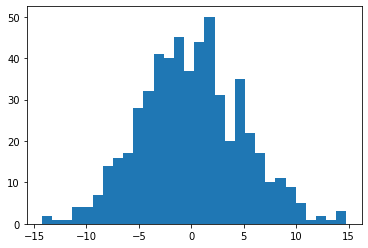

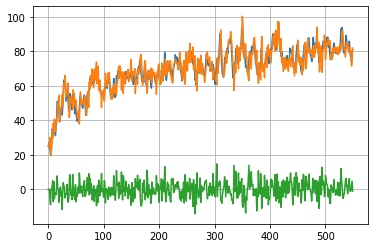

гом-сть с параметрами: T=  0.8967339627646961 интервал =  [0.7465552312581094, 1.3394856242783009]
получилась модель ARMA(1,2) с оценками: ai =  0.9574315435374691 qi =  (0.09571527881248028, -0.16344617509329648) и ещё есть константа:  3.2518280417658603
СКО =  23.62586593921541

 иниформация о моделирование с помощью AR(2):
оценки a_i :  (1.0598903425416215, -0.10701422957676221)
остатки зависимы  со значениями:  Q1 =  17.012281011255745  Xi2_1-a,50 =  7.814727903251179
новые  остатки независимы  со значениями:  Q1 =  0.3993760146789499  Xi2_1-a,50 =  7.814727903251179


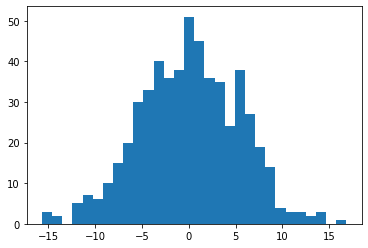

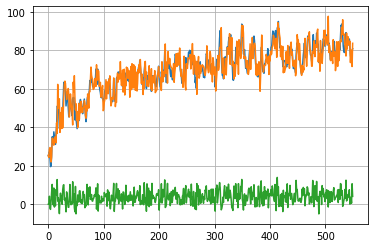

гом-сть с параметрами: T=  1.0819972196432293 интервал=  [0.7465552312581094, 1.3394856242783009]
Получилась модель ARMA(2,2) с оценками: ai =  (1.0598903425416215, -0.10701422957676221) qi =  (-0.005243873183894133, -0.14500679156619561) и ещё есть константа:  3.853385871999702
СКО =  28.16506594588545

 иниформация о моделирование с помощью AR(1) (оценки методом мнк):
оценки AR(1)  методом МНК:  1.0022645374802284
остатки зависимы  со значениями:  Q1 =  28.605144545738217  Xi2_1-a,50 =  7.814727903251179
новые  остатки независимы  со значениями:  Q1 =  2.153288175800882  Xi2_1-a,50 =  7.814727903251179


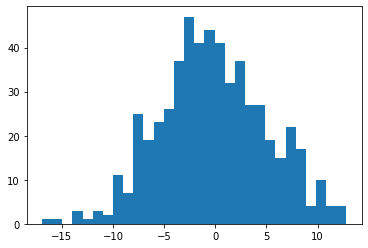

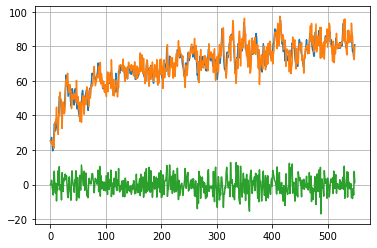

гом-сть с параметрами: T=  0.7629337456189471 интервал =  [0.7465552312581094, 1.3394856242783009]
получилась модель ARMA(1,2) с оценками: ai =  1.0022645374802284 qi =  (0.08464467105973943, -0.17176683243248478) и ещё есть константа:  -0.06084049579337836
СКО =  26.96242518816956

 иниформация о моделирование с помощью AR(2) (оценки методом мнк):
оценки a_i методом МНК:  [-0.65735351  1.65957198]
остатки зависимы  со значениями:  Q1 =  141.49466932921925  Xi2_1-a,50 =  7.814727903251179
новые  остатки независимы  со значениями:  Q1 =  6.88011348743587  Xi2_1-a,50 =  7.814727903251179


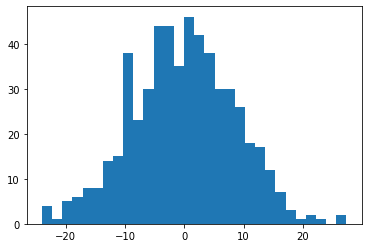

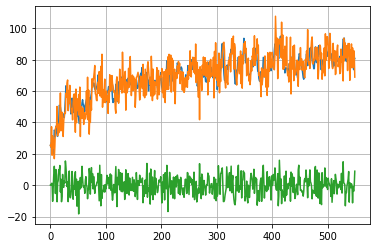

гом-сть с параметрами: T=  1.048783314840522 интервал=  [0.7465552312581094, 1.3394856242783009]
Получилась модель ARMA(2,2) с оценками: ai =  [-0.65735351  1.65957198] qi =  (0.5933207908941068, -0.4299469027227028) и ещё есть константа:  0.09778783438634939
СКО =  74.91883800254844

 иниформация о моделирование с помощью ARIMA(p,1,q):


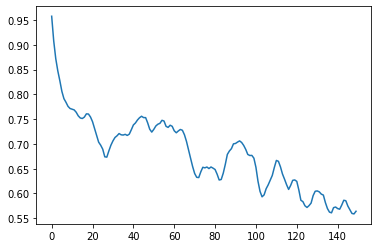

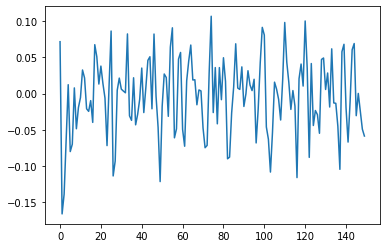

параметр p = 6
коэффициенты ai в модели ARIMA( 6 ,1,0):  [ 0.05211787 -0.18069779 -0.12705803 -0.09573227 -0.01285547 -0.12312794]
остатки независимы  со значениями:  Q1 =  0.317491384098389  Xi2_1-a,50 =  7.814727903251179
гом-сть с параметрами: T=  1.1090193203772332 интервал=  [0.7453328523569646, 1.3416824400503775]
q = 0
СКО первых разностей:  24.17081449666635


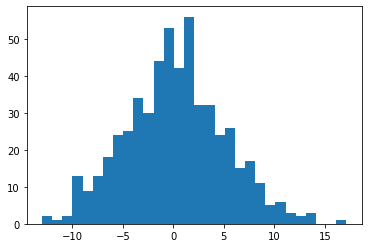

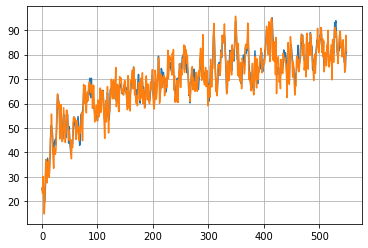

In [ ]:
adress = ['/content/sample_data/АВР_2021.xlsx']
data = pd.read_excel(adress[0]
                #sheet_name= adress[1]
                #usecols = [2],
                )
print(data.head())
Y = np.array(data['Михайлов'])
Y = np.delete(Y,0)
X = np.array([i for i in range(len(Y))])
p = 0.05
print("СРЕДНЕЕ: ", np.mean(Y))
print("ВЫБОРОЧНАЯ ДИСПЕРСИЯ: ", np.var(Y))
trend = kritT1(Y,p)
Yr = rk(Y)
rankY = st.rankdata(Yr)
n = len(Yr)
T = 1 - 6*sum([(rankY[i] - (i+1))**2 for i in range(n)])/(n**3 - n)
T1 = T*math.sqrt((n-2)/(1 - T**2))
statT = S_obr2x(p,n-2)
print('T1: ', T1, statT)
print("Принятие гипотезы существование тренда с помощью ранг. статистики Спирмана: ",
     "ПРИНИМАЕТСЯ" if trend == False else "ОТЕРГАЕТСЯ"," с уровнем значимости ", p)
plot = [True]*5
plot_e = [True]*5
plot[4] = True
plot_e[4] = True
print( "\n","иниформация о моделирование с помощью AR(1):")
ar1 = fitingAR1(Y,drow = plot[0],hist_e = plot_e[0])
print( "\n","иниформация о моделирование с помощью AR(2):")
ar2 = fitingAR2(Y,drow = plot[1],hist_e = plot_e[1])
print( "\n","иниформация о моделирование с помощью AR(1) (оценки методом мнк):")
ar1_mnk = fitingAR1(Y, mnk = True,drow = plot[2],hist_e = plot_e[2])
print( "\n","иниформация о моделирование с помощью AR(2) (оценки методом мнк):")
ar2_mnk = fitingAR2(Y, mnk = True,drow = plot[3],hist_e = plot_e[3])
print( "\n","иниформация о моделирование с помощью ARIMA(p,1,q):")
arima = ARIMA(Y,drow = plot[4],hist_e = plot_e[4],drow_d = False)

In [ ]:
l = 2
l_arim = len(arima[12])
Yar1 = [Y[len(Y)-1]]
Yar1mnk =[Y[len(Y)-1],Y[len(Y)-2]]
Yar2 = [Y[len(Y)-1],Y[len(Y)-2]]
Yar2mnk =[Y[len(Y)-1],Y[len(Y)-2]]
Yarim = [arima[12][l_arim-1-s] for s in range(len(arima[1]))]

for i in range(3):
    f_ar1 = ar1[0] +  ar1[1]*Yar1[0] + (
        sum([ar1[2][j]*ar1[6][len(ar1[6])-j-1] for j in range(len(ar1[2])-i)]) if i<2 else 0)
    Yar1 = np.append(f_ar1,Yar1)

    f_ar2 = ar2[0] +  ar2[1][0]*Yar2[0] + ar2[1][1]*Yar2[1] + (
        sum([ar2[2][j]*ar2[6][len(ar2[6])-j-1] for j in range(len(ar2[2])-i)]) if i<2 else 0)
    Yar2 = np.append(f_ar2,Yar2)

    f_ar1_mnk = ar1_mnk[0] +  ar1_mnk[1]*Yar1mnk[0] + (
        sum([ar1_mnk[2][j]*ar1_mnk[6][len(ar1_mnk[6])-j-1] for j in range(len(ar1_mnk[2])-i)]) if i<2 else 0)
    Yar1mnk = np.append(f_ar1_mnk,Yar1mnk)

    f_ar2_mnk = ar2_mnk[0] +  ar2_mnk[1][0]*Yar2mnk[0] + ar2_mnk[1][1]*Yar2mnk[1] + (
        sum([ar2_mnk[2][j]*ar2_mnk[6][len(ar2_mnk[6])-j-1] for j in range(len(ar2[2])-i)]) if i<2 else 0)
    Yar2mnk = np.append(f_ar2_mnk,Yar2mnk)

    f_arima = arima[0] + sum([arima[1][k]*Yarim[k] for k in range(len(arima[1]))]) + (
        sum([arima[2][s]*arima[6][len(arima[6])-s-1] for s in range(len(arima[2]))]) if i<2 else 0)
    Yarim = np.append(f_arima,Yarim)

arr = [Y[len(Y)-1]]
for i in range(3):
    arr = np.append(Yarim[2-i]+arr[0],arr)
Yarima = arr

In [ ]:
my_ar1 = np.var(ar1[5])*np.sqrt([1,2,3])
my_ar1mnk = np.var(ar1_mnk[5])*np.sqrt([1,2,3])
my_ar2 = np.var(ar2[5])*np.sqrt([1,2,3])
my_ar2mnk = np.var(ar2_mnk[5])*np.sqrt([1,2,3])
my_arima = np.var(arima[5])*np.sqrt([1,2,3])

t_krit_ar1 = st.t.interval(0.95, len(Y) - 3, loc=0, scale=1)[1]
t_krit_ar2 = st.t.interval(0.95, len(Y) - 4, loc=0, scale=1)[1]
t_krit_arima = st.t.interval(0.95, len(Y) - 6, loc=0, scale=1)[1]

print("------------------------")
print("прогнозы:")
print("для модели ARMA(1,2): ", [f"{Yar1[2-i]}"+" +- "+f"{t_krit_ar1*my_ar1[i]}"  for i in range(3)])
print("для модели ARMA(1,2) (оценки мнк): ", [f"{Yar1mnk[2-i]}"+" +- "+f"{t_krit_ar1*my_ar1mnk[i]}"  for i in range(3)])
print("для модели ARMA(2,2): ", [f"{Yar2[2-i]}"+" +- "+f"{t_krit_ar2*my_ar2[i]}"  for i in range(3)])
print("для модели ARMA(2,2) (оценки мнк): ", [f"{Yar2mnk[2-i]}"+" +- "+f"{t_krit_ar2*my_ar2mnk[i]}"  for i in range(3)])
print("для модели ARiMA(6,1,0): ", [f"{Yarima[2-i]}"+" +- "+f"{t_krit_arima*my_arima[i]}"  for i in range(3)])

------------------------
прогнозы:
для модели ARMA(1,2):  ['81.08079261997189 +- 25.581577687546844', '81.24661475364036 +- 36.177814112629704', '81.03989981253785 +- 44.30859229260148']
для модели ARMA(1,2) (оценки мнк):  ['81.27850582958477 +- 26.38966130956736', '81.76813985980687 +- 37.320616930422695', '81.89246638141458 +- 45.708234182705304']
для модели ARMA(2,2):  ['81.12152541584567 +- 25.69693075660033', '81.17736286043484 +- 36.34094798734651', '81.21133125630303 +- 44.50838966901112']
для модели ARMA(2,2) (оценки мнк):  ['81.8087957462523 +- 73.4039179148774', '83.23258343968827 +- 103.80881624654103', '81.15214152553443 +- 127.13931530318298']
для модели ARiMA(6,1,0):  ['80.92440313635018 +- 47.82393418535937', '80.9872021834395 +- 67.63325633097352', '80.49138728595057 +- 82.83348382687252']
